# Stage 2 AI training: time window points

This stage focuses on selecting the **optimal time window's length**. Different architectures and rotational frames will be used for every time window option.

In [1]:
# Import packages:
import MLQDM.MLmodel as ML_MLmodel
import MLQDM.timewindows as ML_twdw
import tensorflow as tf

# Check available GPU:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-11-09 14:09:53.769321: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 14:09:53.779994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731121793.792251  568683 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731121793.796270  568683 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 14:09:53.809018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


## Load original data and general parameters
Load data from files (many segments) and store information in dataframes, one for each segment. The original data is in the **Laboratory rotational frame (RF1)**.

There are two possible sets of target labels, coming for the 'linear approximation' of 'physical model' approaches regarding the interpolated positions. You must choose one as {interp} for the training stage:
* **'lin_approx'** : linear approximation.
* **'phys_model'** : physical model based on acceleration profile.

In [2]:
# Choose Z-position interpolation method:
interp = 'lin_approx' # 'phys_model' or 'lin_approx'

# Prepare files information:
data_path =  '../Data/' # Datafiles path
gen_pars_path = 'ML_parameters/'

# Load data, general hyperparameters and rotational frames:
data, hypers, RFs = ML_MLmodel.load_data_and_gen_pars(
    data_path,gen_pars_path,interp=interp,final_stage=False)

## Generate time windows

### Load original data

Each data segment is processed into time windows, which must have a fixed time length (or equivalently, fixed number of points) by default. However, as the original data is stored in the Time_Wdw object, it can be reshaped later.

The distribution of training and testing datasets is chosen here. The validation dataset is included within the training dataset.

Summary for time windows within training and testing datasets:

Number of points for every time window: 20
Time resolution: 0.1000 s

 --------------------  Training dataset  -------------------- 

time_0_to_59min: 35719 points, 59 min
time_420_to_595min: 105475 points, 175 min
time_600_to_717min: 70561 points, 117 min
Total points/time: 211755 / 5.88 hours

 --------------------  Testing dataset  -------------------- 

time_240_to_419min: 107138 points, 178 min
time_60_to_239min: 107601 points, 179 min
Total points/time: 214739 / 5.96 hours


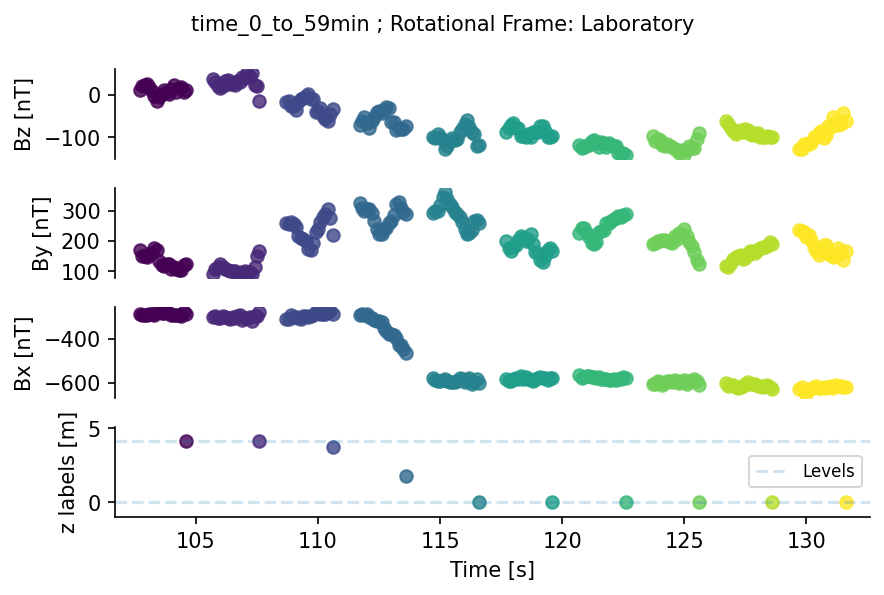

In [3]:
# Prepare time windows:
wdw_pp = 20
train_segm = [0,2,4] if interp == 'phys_model' else [2,3,4]
t_wdws_train, t_wdws_test = ML_twdw.prepare_time_windows(
    data,wdw_pp,train_segm=train_segm,
    plot_instances=True,instances=10,start_wdw=1025,stride_pp=30)

### Time Windows

From Stage 1 analysis, we've determined that only the full vector data, meaning all three $(Bx,By,Bz)$ magnetic components, is robust against rotations and has about 90% accuracy for position predictions using a 1-meter threshold.

In this Stage 2, we optimize the **[number of points for the Time Windows]**. Each input option will be combined with three different architectures:

1. A single Convolutional Neural Network (CNN) with 32 filters and kernel size 5 + Flattening layer + Two consecutive Dense Neural Network (DNN) with 512 neurons each.
2. Two consecutive CNN with 32 filters each and kernel sizes 8 and 4, respectively, + Flattening layer + Two consecutive DNN with 512 neurons each.
3. Three consecutive DNN with 1024, 512, 512 neurons, respectively.

In all cases, the last output layer is a DNN with a single neuron and linear activation, which predicts a single value for the elevator Z-position, units [m], representing the position at the end of the time window.

The general hyperparameters for all ML models are defined according to the 'ML_gen_pars_S1to6.json' file. In addition, the following hyperparameters are also common to all ML models:

* "Magnetic_Components": ['Bx','By','Bz'].
* "Dropout_Fraction": 0.
* "Activation_Function": 'relu'.
* "Optimizer": 'adam'.
* "Learning_Rate": 0.005.

In this stage, the standard rotational frames (RF1,RF2,RF3), described in the 'ML_RF_S1to6.json' file, are used to train and evaluate each ML model.

In [4]:
# Define additional hyperparameters:
extra_hypers = {
    "Magnetic_Components": ['Bx','By','Bz'],
    "Dropout_Fraction": 0,
    "Activation_Function": 'relu',
    "Optimizer": 'adam',
    "Learning_Rate": 0.005
}

# Define the architecture options:
arch1 = {
    "Convolutional_Network": True,
    "Conv_Layers": [[32,5]],
    "Pool_Layers": [None],
    "Flatten_Average": True,
    "Dens_Layers": [512,512],
    "Model_Name": "S2_C5_"
}
arch2 = {
    "Convolutional_Network": True,
    "Conv_Layers": [[32,8],[32,4]],
    "Pool_Layers": [None,None],
    "Flatten_Average": True,
    "Dens_Layers": [512,512],
    "Model_Name": "S2_C8_C4_"
}
arch3 = {
    "Convolutional_Network": False,
    "Dens_Layers": [1024,512,512],
    "Model_Name": "S2_D1024D512D512"
}

# Combine all hyperparameters information and architecture options:
arch_opts = [dict(list(hypers.items())+list(extra_hypers.items())+list(arch.items()))\
             for arch in [arch1,arch2,arch3]]

# Options for seeds:
seed_opts = [0,1,2]

# Prepare rotational frame options:
RF_opts = list(RFs.values())

In [5]:
# Options for number of points in time windows:
import numpy as np
pp_opts = np.concatenate([
    np.arange(1,10,1),np.arange(10,20,2),np.arange(20,60,4),np.arange(60,124+1,8)
    ],axis=0)

In [6]:
# Prepare file path to export results:
results_path = f'../Results/'
# Prepare file path to check on already trained models and avoid repetitions:
check_rep_model = f'../Results/Stage2_{interp}_all_Train_s1s4s5_Test_s2s3.csv'

# Train all models:
df_results = ML_MLmodel.train_stage2(
    pp_opts,arch_opts,RF_opts,t_wdws_train,t_wdws_test,interpolation=interp,
    seed_opts=seed_opts,results_path=results_path,
    check_rep_model=check_rep_model,
    quick_timing_test=False
)

I0000 00:00:1731121796.261302  568683 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 76 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
2024-11-09 14:09:56.271601: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1193] failed to allocate 76.88MiB (80609280 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


Epoch 1/200


I0000 00:00:1731121797.318429  568792 service.cc:148] XLA service 0x71f998004bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731121797.318456  568792 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-09 14:09:57.338065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1731121797.414938  568792 cuda_dnn.cc:534] Could not create cudnn handle: <unknown cudnn status: 4004>
E0000 00:00:1731121797.414979  568792 cuda_dnn.cc:538] Memory usage: 3014656 bytes free, 8318484480 bytes total.
E0000 00:00:1731121797.431339  568792 cuda_dnn.cc:534] Could not create cudnn handle: <unknown cudnn status: 4004>
E0000 00:00:1731121797.431364  568792 cuda_dnn.cc:538] Memory usage: 3014656 bytes free, 8318484480 bytes total.
2024-11-09 14:09:57.434429: W tensorflow/core/fr

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_568683/2446769323.py", line 7, in <module>

  File "/home/meneses/BACKUP - AI Chris experiment/00_Lift/MLQDM/src/MLQDM/MLmodel.py", line 867, in train_stage2

  File "/home/meneses/BACKUP - AI Chris experiment/00_Lift/MLQDM/src/MLQDM/MLmodel.py", line 332, in train_model

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_1671]